In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing as pre
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [2]:
# Load data
data = pd.read_csv('final-dataset.csv')

In [3]:
# Drop non-relevant columns and extract features/labels
X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
y = data['Label']


In [4]:
# Scale features
X = pre.scale(X)

# Reshape X to 3D for GRU (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Assuming single timestep

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


In [5]:
# ========================= GRU Model =========================
def create_gru_model(optimizer='adam', units=64, dropout_rate=0.5):
    model = Sequential()
    model.add(GRU(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units // 2))  # Reduce units in second GRU layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model for GridSearchCV
model = KerasClassifier(build_fn=create_gru_model, verbose=0)

C:\Users\Yash Srivastava\AppData\Local\Temp\ipykernel_4232\1034287442.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_gru_model, verbose=0)


In [ ]:
# Hyperparameter grid
parameters_gru = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'units': [64, 128],
    'dropout_rate': [0.2, 0.5]
}

In [7]:
# Perform Grid Search for GRU model
grid_search_gru = GridSearchCV(estimator=model, param_grid=parameters_gru, n_jobs=-1, cv=3)
grid_search_gru.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022A750B2CD0>,
             n_jobs=-1,
             param_grid={'batch_size': [16, 32], 'dropout_rate': [0.2, 0.5],
                         'epochs': [50, 100], 'optimizer': ['adam', 'rmsprop'],
                         'units': [64, 128]})

In [8]:
# Best model
best_model_gru = grid_search_gru.best_estimator_

# Predict using GRU model
y_pred_gru = best_model_gru.predict(x_test)
y_pred_gru = (y_pred_gru > 0.5).astype(int)  # Convert probabilities to binary labels


7/7 [==============================] - 2s 3ms/step


In [9]:
# ========================= Model Evaluation =========================
tn_gru, fp_gru, fn_gru, tp_gru = confusion_matrix(y_test, y_pred_gru).ravel()
specificity_gru = tn_gru / (tn_gru + fp_gru)
accuracy_gru = (tp_gru + tn_gru) / (tp_gru + tn_gru + fp_gru + fn_gru)
sensitivity_gru = tp_gru / (tp_gru + fn_gru)
precision_gru= (tp_gru/(tp_gru+fp_gru))
f1_Score = 2 * (precision_gru * sensitivity_gru) / (precision_gru + sensitivity_gru)


print("GRU Model Metrics:")
print(f"Specificity: {specificity_gru}")
print(f"Accuracy: {accuracy_gru}")
print(f"Sensitivity: {sensitivity_gru}")
print(f"precision :  { precision_gru}")
print(f"F1_Score : {f1_Score}")

GRU Model Metrics:
Specificity: 0.7547169811320755
Accuracy: 0.8285714285714286
Sensitivity: 0.9038461538461539
precision :  0.7833333333333333
F1_Score : 0.8392857142857143


7/7 [==============================] - 0s 3ms/step


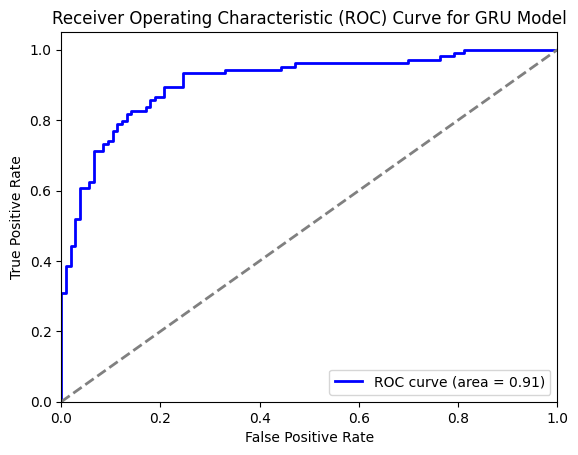

In [10]:
# ========================= ROC Curve =========================
y_pred_proba_gru = best_model_gru.predict_proba(x_test)[:, 1]  # Probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_gru)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for GRU Model')
plt.legend(loc='lower right')
plt.show()

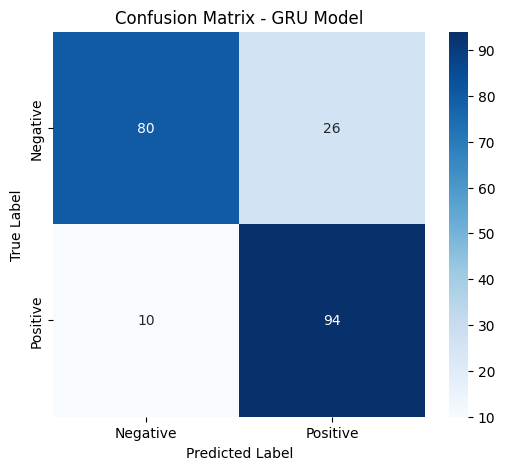

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_gru)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - GRU Model")
plt.show()
